In [13]:
!pip install pydicom matplotlib numpy SimpleITK dcmqi monai
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from monai.transforms import Compose
import threading

In [14]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# PROCESSING FUNCTIONS (FIXED)
def pad_to_depth(x, target_depth):
    current_depth = x.shape[1]
    padded_depth = ((current_depth + 3) // 4) * 4
    pad_amount = padded_depth - current_depth
    if pad_amount > 0:
        pad_tensor = torch.zeros(x.size(0), pad_amount, x.size(2), x.size(3), 
                              device=x.device, dtype=x.dtype)
        x = torch.cat([x, pad_tensor], dim=1)
    return x

def get_patient_folders(root_path):
    return [
        os.path.join(root_path, d) 
        for d in os.listdir(root_path) 
        if os.path.isdir(os.path.join(root_path, d)) 
        and "im_1" in os.listdir(os.path.join(root_path, d))
    ]
    
def get_dicom_series(directory):

    reader = sitk.ImageSeriesReader()
    try:
        series_ids = reader.GetGDCMSeriesIDs(directory)
        if not series_ids:
            return None
        
        dicom_files = reader.GetGDCMSeriesFileNames(directory, series_ids[0])
        reader.SetFileNames(dicom_files)
        return reader.Execute()
    except Exception as e:

        print(f"Error loading DICOM from {directory}: {str(e)}")
        return None

def convert_seg_dicom_to_mha(im3_path, output_base_dir, patient_id):
    seg_dcm_files = [f for f in os.listdir(im3_path) if f.lower().endswith(".dcm")]
    if not seg_dcm_files:
        return None

    output_dir = os.path.join(output_base_dir, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    convert_cmd = [
        "segimage2itkimage",
        "--inputDICOM", os.path.join(im3_path, seg_dcm_files[0]),
        "--outputDirectory", output_dir,
        "-t", "mha",
        "-p", "segmentation"
    ]

    result = subprocess.run(convert_cmd, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Conversion failed for {patient_id}. Error:\n{result.stderr}")
        return None

    mha_files = [f for f in os.listdir(output_dir) 
               if f.startswith("segmentation") and f.endswith(".mha")]
    return os.path.join(output_dir, mha_files[0]) if mha_files else None

def process_files():
    processed_data = []
    target_shape = (128, 128, 72)

    base_path = "/kaggle/input/ctpel13/"
    working_dir = "/kaggle/working/converted_segmentations/"
    os.makedirs(working_dir, exist_ok=True)

    patients = get_patient_folders(base_path)

    for patient in patients:
        patient_id = os.path.basename(patient)
        print(f"\nProcessing: {patient_id}")
        
        ct_path = os.path.join(patient, "im_1")
        seg_path = os.path.join(patient, "im_3")

        # 1. Load CT scan
        ct_image = get_dicom_series(ct_path)
        if not ct_image:
            print(f"Skipping {patient_id} - CT load failed")
            continue

        # 2. Process segmentation
        seg_file = convert_seg_dicom_to_mha(seg_path, working_dir, patient_id)
        if not seg_file:
            print(f"Skipping {patient_id} - Segmentation conversion failed")

            continue
            
        try:
            # 3. Load and resample segmentation
            seg_image = sitk.ReadImage(seg_file)
            
            resampler = sitk.ResampleImageFilter()
            resampler.SetReferenceImage(ct_image)
            resampler.SetInterpolator(sitk.sitkNearestNeighbor)
            resampled_seg = resampler.Execute(seg_image)


            # 4. Convert to numpy arrays
            ct_array = sitk.GetArrayFromImage(ct_image)  # (D, H, W)
            seg_array = sitk.GetArrayFromImage(resampled_seg)

            # 5. Verify dimensions
            if ct_array.shape != seg_array.shape:
                print(f"Shape mismatch after resampling: {ct_array.shape} vs {seg_array.shape}")
                continue

            # 6. Convert to tensors and resize
            ct_tensor = torch.tensor(ct_array).float().unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)
            seg_tensor = torch.tensor(seg_array).float().unsqueeze(0).unsqueeze(0)

            ct_resized = F.interpolate(ct_tensor, size=target_shape, mode='trilinear').squeeze()
            seg_resized = F.interpolate(seg_tensor, size=target_shape, mode='nearest').squeeze()

            seg_final = (seg_resized > 0.5).float().numpy()

            # 8. Store processed data
            # In process_files():
            processed_data.append({
                'filename': patient_id,
                'ct': ct_resized.numpy().astype(np.float32),  # (H, W, D)
                'seg': seg_final.astype(np.float32),          # (H, W, D)
                'original_shape': ct_array.shape,
                'processed_shape': target_shape
            })

        except Exception as e:
            print(f"Error processing {patient_id}: {str(e)}")
            continue

    return processed_data
processed_data = process_files()
print(f"Processed {len(processed_data)} samples")
    


Processing: 5F3E9A19B47C2EAD

Processing: 5BE1ADA090E1EB9C

Processing: 31E1D28ADE38ABA9

Processing: 3F2E8686E524ABCA

Processing: 02CC41B35F6C8145

Processing: 56CA1FFF09488D70

Processing: 4CD9674D8668698C

Processing: 08FF8BEBB1FB756A

Processing: 5B6D4F35387FF59C

Processing: 11BC311A21A22818

Processing: 0AD7CE889B4FB16F

Processing: 1D1D8ECAC96EFAA5

Processing: 9E8122CBCB107AC3

Processing: 64C38A134BB232A0

Processing: 9FB69D514F663A2B

Processing: 26DD3530EC0566E9

Processing: 3B3256E6694B0ABE

Processing: 06BE6C20741AFADD

Processing: 7A84C4C355AAF522

Processing: 0A44743795D421F7

Processing: 47DF7844DE611A35

Processing: 5A48C85404AB8CFD

Processing: 08D745849406C9D5

Processing: 2DD9A1B65346D271

Processing: 56A09B65B422A9C3

Processing: 0FC3188AAA7E6851

Processing: 3E934A9F0D559A6F

Processing: 7D8E6E1C05D04B9D

Processing: 0D0C5A034B94C222
Processed 29 samples


Keys: dict_keys(['filename', 'ct', 'seg', 'original_shape', 'processed_shape'])
CT shape: (128, 128, 72)
Seg shape: (128, 128, 72)
Seg unique values: [0. 1.]


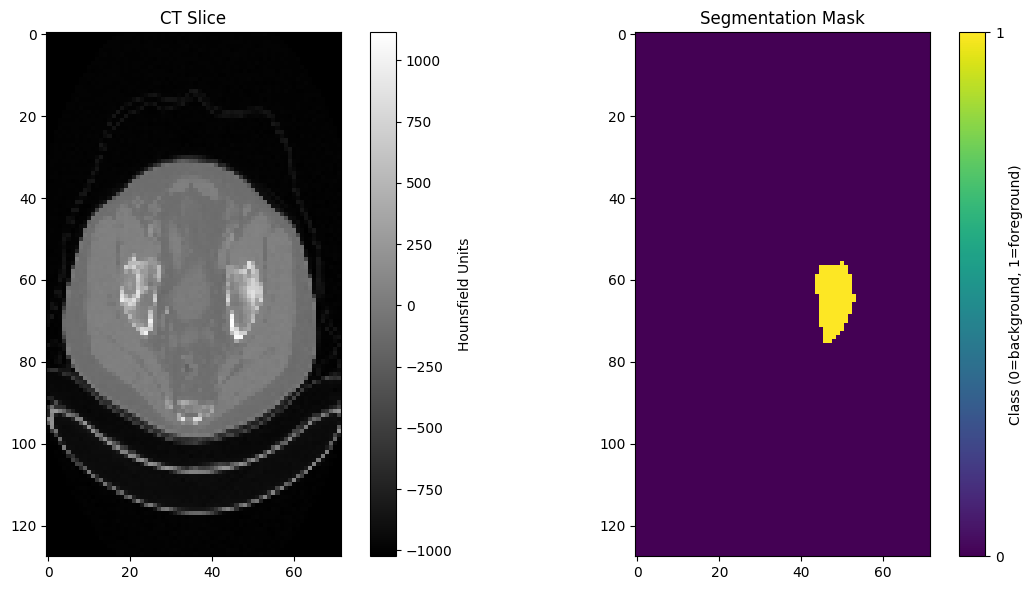

In [15]:
# Check first sample
sample = processed_data[14]
print("Keys:", sample.keys())
print("CT shape:", sample['ct'].shape)
print("Seg shape:", sample['seg'].shape)
print("Seg unique values:", np.unique(sample['seg']))
def plot_sample(ct, seg, slice_idx=36):
    """Plot CT slice and segmentation mask side by side"""
    plt.figure(figsize=(12, 6))
    
    # CT slice
    plt.subplot(121)
    plt.imshow(ct[slice_idx], cmap='gray')
    plt.title("CT Slice")
    plt.colorbar(label='Hounsfield Units')
    
    # Segmentation mask
    plt.subplot(122)
    plt.imshow(seg[slice_idx], cmap='viridis')
    plt.title("Segmentation Mask")
    plt.colorbar(ticks=[0, 1], label='Class (0=background, 1=foreground)')
    
    plt.tight_layout()
    plt.show()

# Plot sample
plot_sample(sample['ct'], sample['seg'])


Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

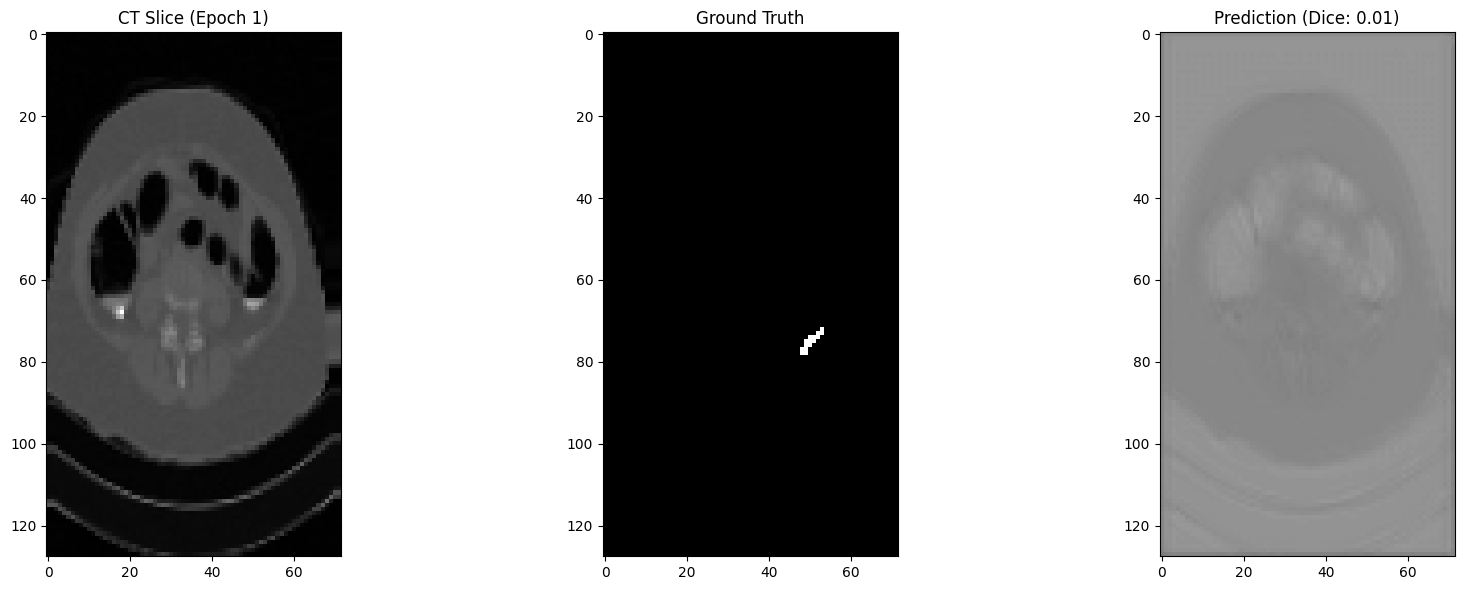

Epoch 1: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 1
Train Loss: 1.6939 | Dice: 0.0109
New best model saved with Dice: 0.0109


Epoch 2: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 2
Train Loss: 1.3914 | Dice: 0.0167
New best model saved with Dice: 0.0167


Epoch 3: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 3
Train Loss: 1.2409 | Dice: 0.0221
New best model saved with Dice: 0.0221


Epoch 4: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 4
Train Loss: 1.1594 | Dice: 0.0314
New best model saved with Dice: 0.0314


Epoch 5: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 5
Train Loss: 1.1007 | Dice: 0.0516
New best model saved with Dice: 0.0516


Epoch 6:   0%|          | 0/15 [00:00<?, ?it/s]

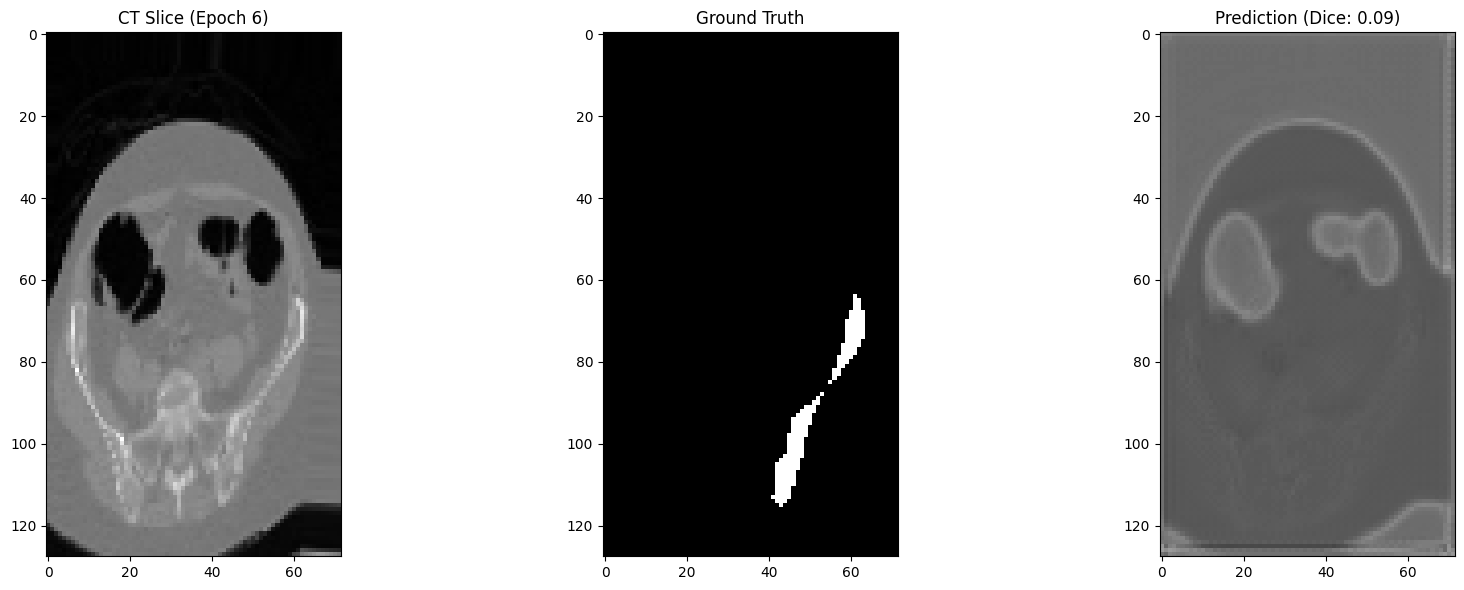

Epoch 6: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 6
Train Loss: 1.0508 | Dice: 0.0975
New best model saved with Dice: 0.0975


Epoch 7: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 7
Train Loss: 1.0165 | Dice: 0.1881
New best model saved with Dice: 0.1881


Epoch 8: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 8
Train Loss: 0.9882 | Dice: 0.2586
New best model saved with Dice: 0.2586


Epoch 9: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 9
Train Loss: 0.9675 | Dice: 0.3072
New best model saved with Dice: 0.3072


Epoch 10: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 10
Train Loss: 0.9456 | Dice: 0.3672
New best model saved with Dice: 0.3672


Epoch 11:   0%|          | 0/15 [00:00<?, ?it/s]

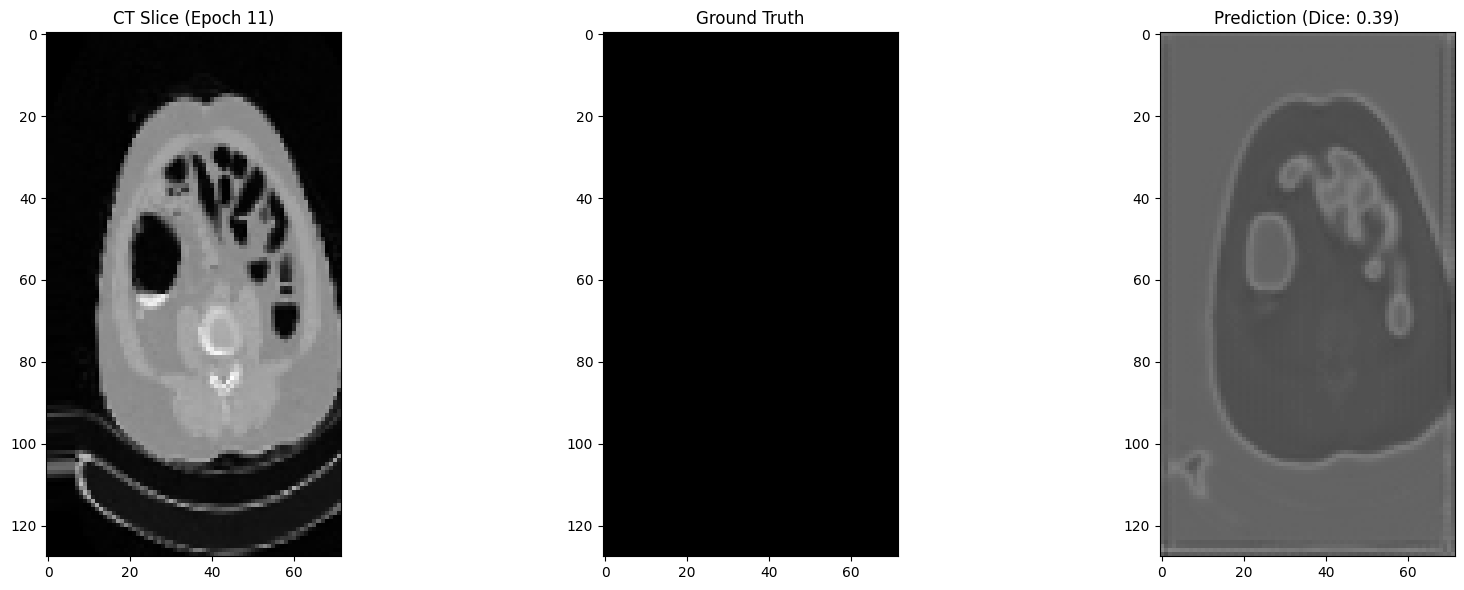

Epoch 11: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 11
Train Loss: 0.9227 | Dice: 0.4462
New best model saved with Dice: 0.4462


Epoch 12: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 12
Train Loss: 0.9004 | Dice: 0.4882
New best model saved with Dice: 0.4882


Epoch 13: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 13
Train Loss: 0.8818 | Dice: 0.4365


Epoch 14: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 14
Train Loss: 0.8638 | Dice: 0.5154
New best model saved with Dice: 0.5154


Epoch 15: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 15
Train Loss: 0.8495 | Dice: 0.4768


Epoch 16:   0%|          | 0/15 [00:00<?, ?it/s]

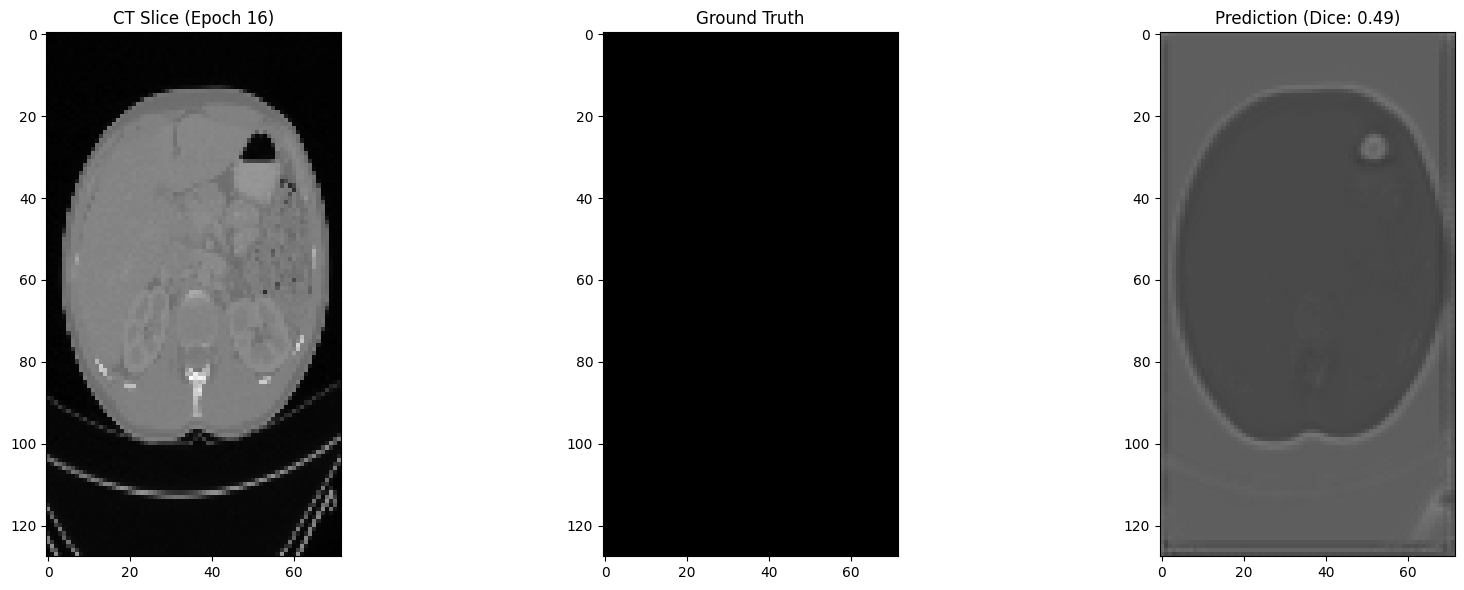

Epoch 16: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 16
Train Loss: 0.8279 | Dice: 0.5219
New best model saved with Dice: 0.5219


Epoch 17: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 17
Train Loss: 0.8121 | Dice: 0.4979


Epoch 18: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 18
Train Loss: 0.7951 | Dice: 0.5104


Epoch 19: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 19
Train Loss: 0.7825 | Dice: 0.4948


Epoch 20: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 20
Train Loss: 0.7660 | Dice: 0.5397
New best model saved with Dice: 0.5397


Epoch 21:   0%|          | 0/15 [00:00<?, ?it/s]

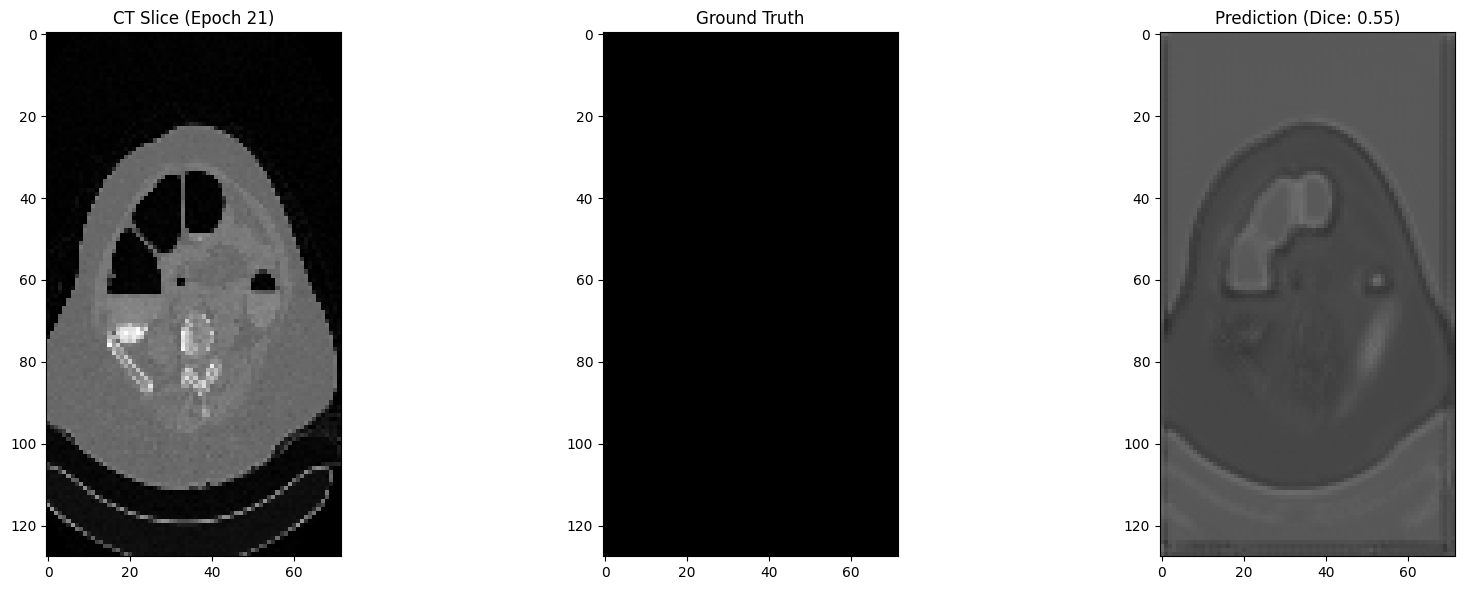

Epoch 21: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 21
Train Loss: 0.7602 | Dice: 0.4781


Epoch 22: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 22
Train Loss: 0.7451 | Dice: 0.5069


Epoch 23: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 23
Train Loss: 0.7342 | Dice: 0.5204


Epoch 24: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 24
Train Loss: 0.7225 | Dice: 0.5179


Epoch 25: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 25
Train Loss: 0.7149 | Dice: 0.5238


Epoch 26:   0%|          | 0/15 [00:00<?, ?it/s]

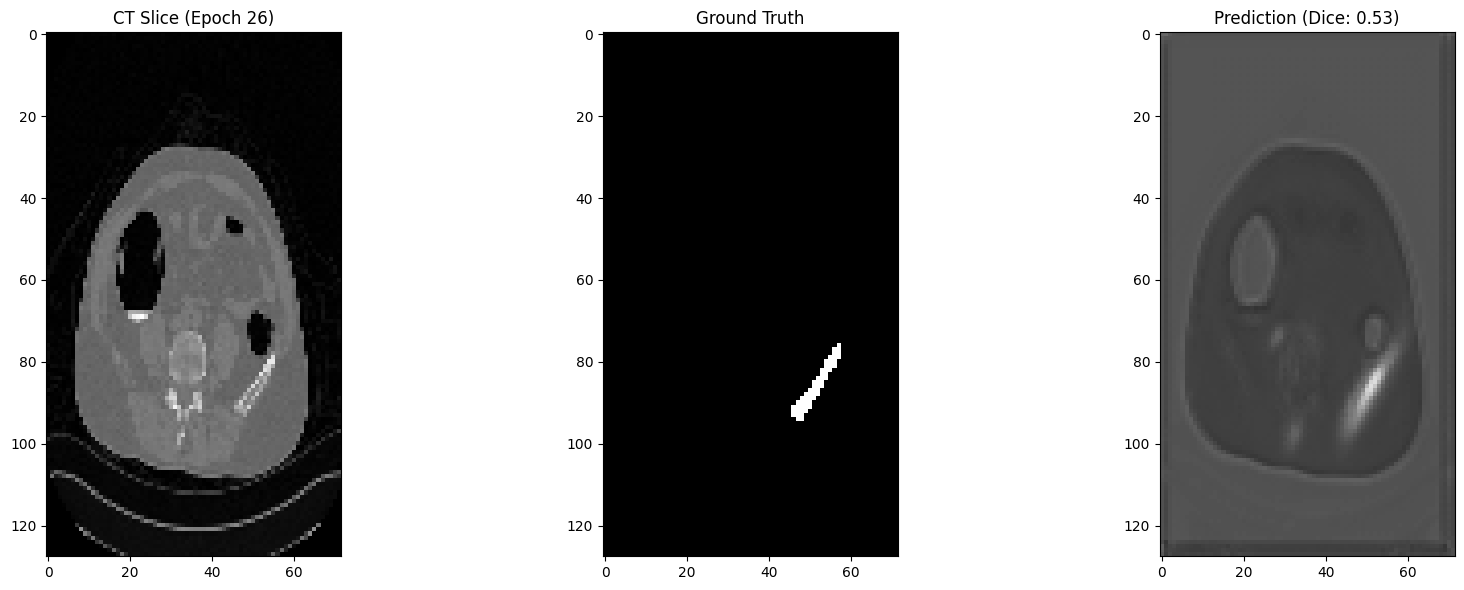

Epoch 26: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 26
Train Loss: 0.7032 | Dice: 0.5210


Epoch 27: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 27
Train Loss: 0.6915 | Dice: 0.5402
New best model saved with Dice: 0.5402


Epoch 28: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 28
Train Loss: 0.6806 | Dice: 0.5330


Epoch 29: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]



Epoch 29
Train Loss: 0.6689 | Dice: 0.5432
New best model saved with Dice: 0.5432


Epoch 30: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 30
Train Loss: 0.6609 | Dice: 0.5830
New best model saved with Dice: 0.5830


Epoch 31:   0%|          | 0/15 [00:00<?, ?it/s]

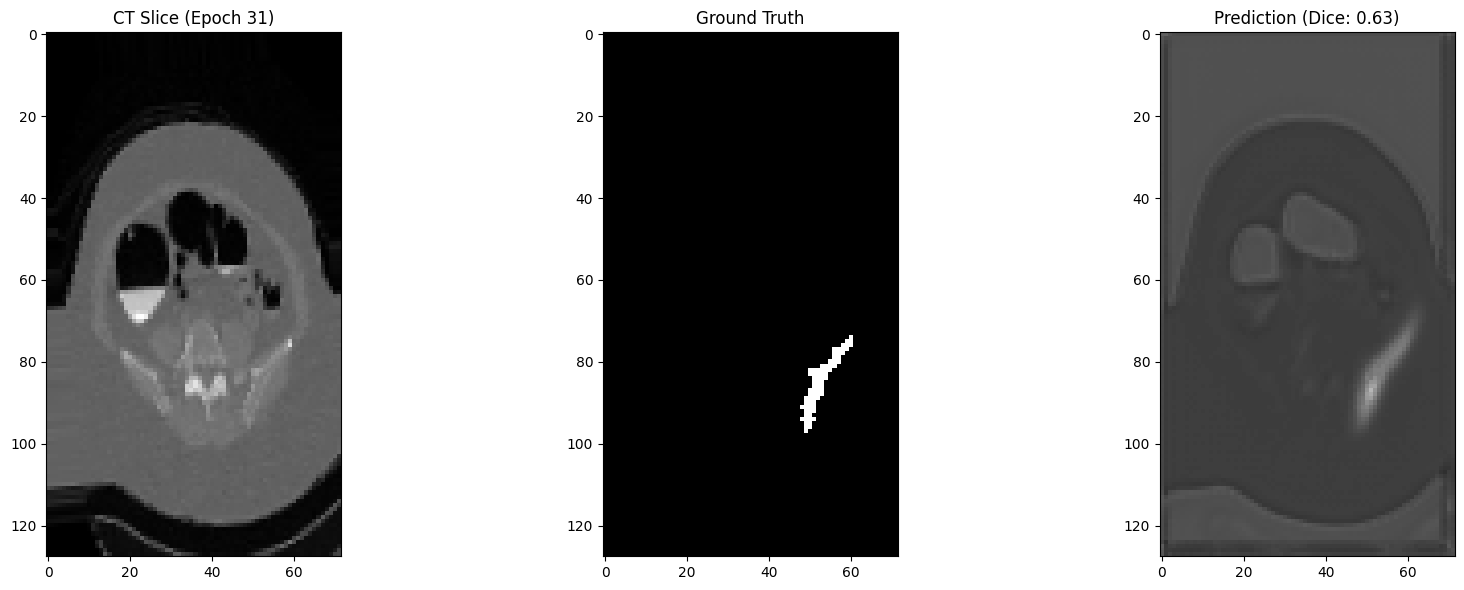

Epoch 31: 100%|██████████| 15/15 [00:28<00:00,  1.91s/it]



Epoch 31
Train Loss: 0.6498 | Dice: 0.5844
New best model saved with Dice: 0.5844


Epoch 32: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 32
Train Loss: 0.6396 | Dice: 0.6114
New best model saved with Dice: 0.6114


Epoch 33: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 33
Train Loss: 0.6305 | Dice: 0.5921


Epoch 34: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 34
Train Loss: 0.6235 | Dice: 0.5968


Epoch 35: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 35
Train Loss: 0.6135 | Dice: 0.5850


Epoch 36:   0%|          | 0/15 [00:00<?, ?it/s]

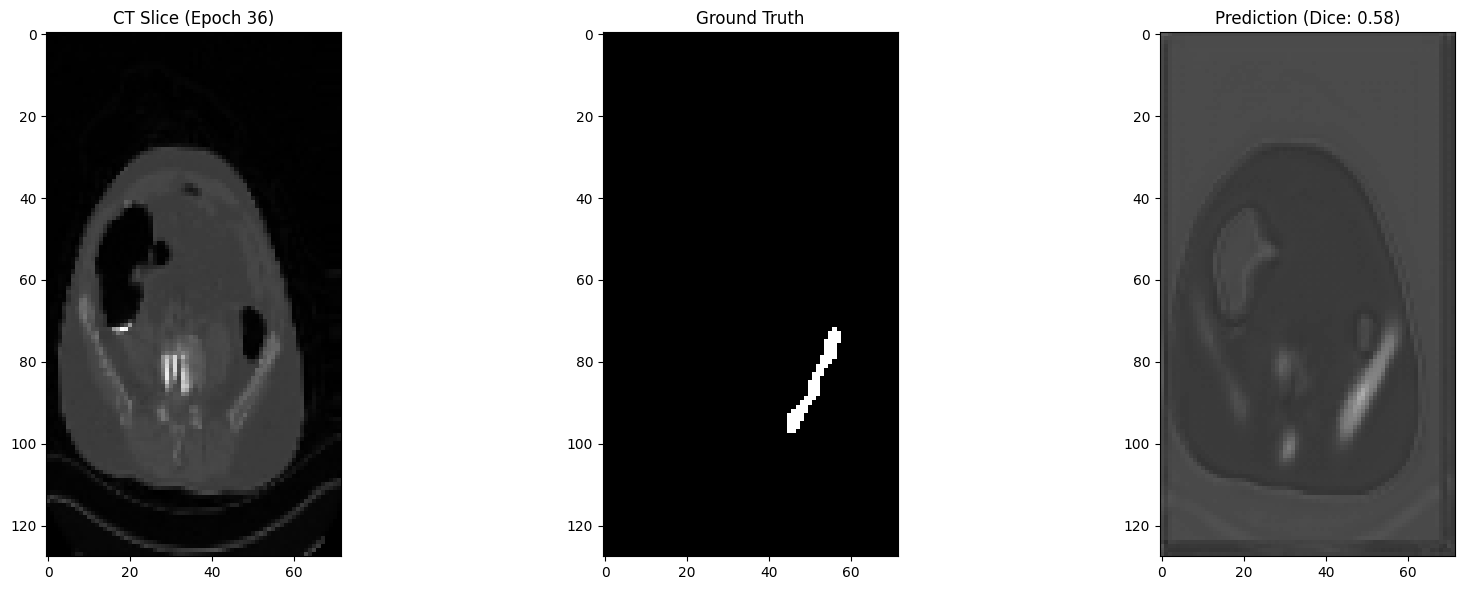

Epoch 36: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 36
Train Loss: 0.6068 | Dice: 0.6085


Epoch 37: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 37
Train Loss: 0.5965 | Dice: 0.6415
New best model saved with Dice: 0.6415


Epoch 38: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 38
Train Loss: 0.5863 | Dice: 0.6471
New best model saved with Dice: 0.6471


Epoch 39: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 39
Train Loss: 0.5829 | Dice: 0.6524
New best model saved with Dice: 0.6524


Epoch 40: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 40
Train Loss: 0.5712 | Dice: 0.6508


Epoch 41:   0%|          | 0/15 [00:00<?, ?it/s]

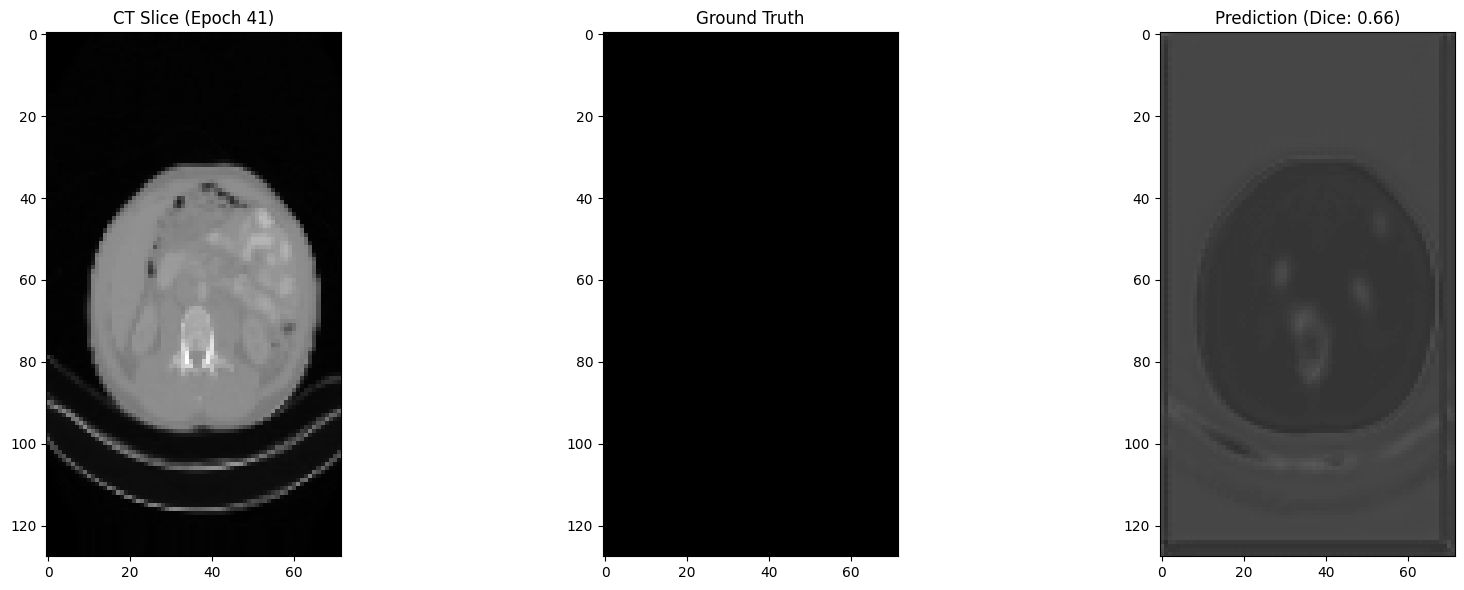

Epoch 41: 100%|██████████| 15/15 [00:28<00:00,  1.90s/it]



Epoch 41
Train Loss: 0.5632 | Dice: 0.6351


Epoch 42: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]



Epoch 42
Train Loss: 0.5540 | Dice: 0.6609
New best model saved with Dice: 0.6609


Epoch 43: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 43
Train Loss: 0.5441 | Dice: 0.6663
New best model saved with Dice: 0.6663


Epoch 44: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 44
Train Loss: 0.5375 | Dice: 0.6715
New best model saved with Dice: 0.6715


Epoch 45: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 45
Train Loss: 0.5269 | Dice: 0.7075
New best model saved with Dice: 0.7075


Epoch 46:   0%|          | 0/15 [00:00<?, ?it/s]

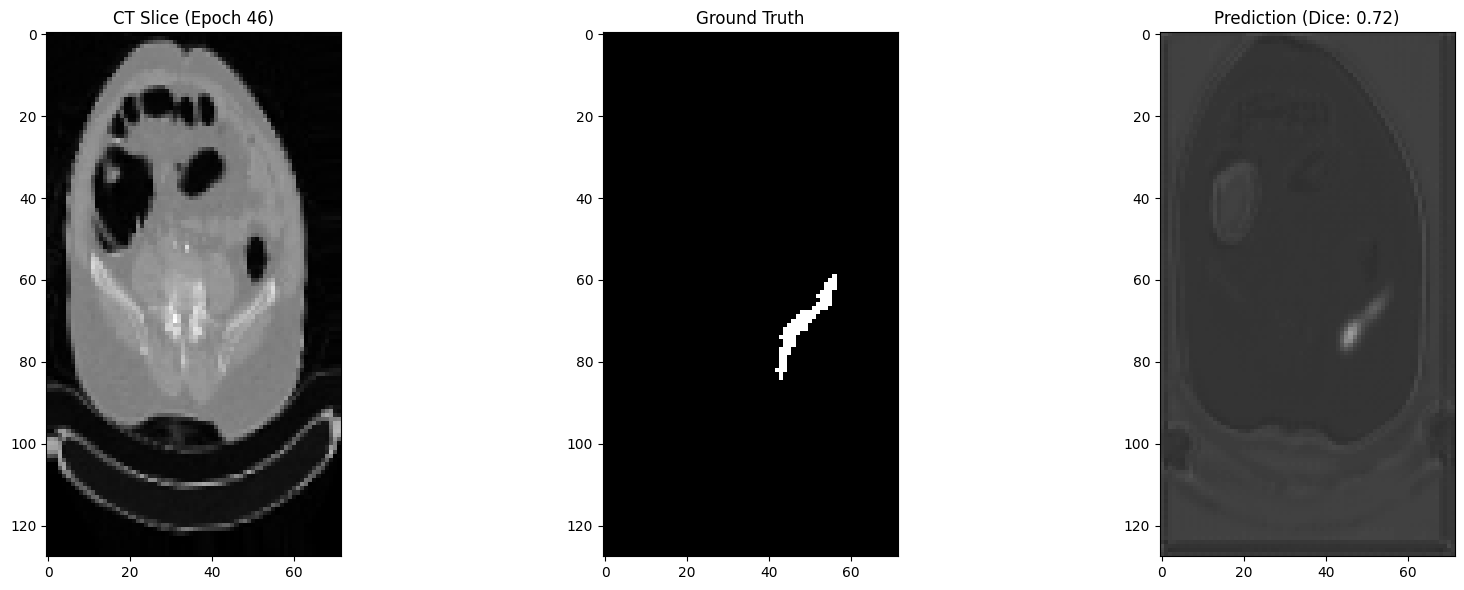

Epoch 46: 100%|██████████| 15/15 [00:28<00:00,  1.89s/it]



Epoch 46
Train Loss: 0.5191 | Dice: 0.7163
New best model saved with Dice: 0.7163


Epoch 47: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 47
Train Loss: 0.5112 | Dice: 0.7165
New best model saved with Dice: 0.7165


Epoch 48: 100%|██████████| 15/15 [00:27<00:00,  1.85s/it]



Epoch 48
Train Loss: 0.5039 | Dice: 0.7219
New best model saved with Dice: 0.7219


Epoch 49: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]



Epoch 49
Train Loss: 0.4965 | Dice: 0.7307
New best model saved with Dice: 0.7307


Epoch 50: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


Epoch 50
Train Loss: 0.4894 | Dice: 0.7545
New best model saved with Dice: 0.7545


In [16]:
# %% --------------------
# PART 0: IMPORTS (UPDATE MONAI TRANSFORMS)
# %% --------------------
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    RandAffined,
    RandFlipd,
    ScaleIntensityd,
    EnsureChannelFirstd,
    ToTensord,
    LambdaD
)

# %% --------------------
# PART 2: DATASET CLASS (CORRECTED)
# %% --------------------
class CTDataset(Dataset):
    def __init__(self, processed_data):
        self.data = processed_data
        self.transform = Compose([
            LambdaD(keys=['ct', 'seg'], func=lambda x: x[np.newaxis, ...]),
            ScaleIntensityd(keys=['ct'], minv=-1000.0, maxv=1000.0),
            RandAffined(
                keys=['ct', 'seg'],
                prob=0.3,
                rotate_range=(0.05, 0.05, 0.05),
                translate_range=(5, 5, 2),
                scale_range=(0.08, 0.08, 0.08),
                padding_mode='border',
                mode=('bilinear', 'nearest')
            ),
            RandFlipd(
                keys=['ct', 'seg'],
                spatial_axis=0,
                prob=0.5
            ),
            ToTensord(keys=['ct', 'seg'], dtype=torch.float32)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        data_dict = {
            'ct': sample['ct'].astype(np.float32),
            'seg': sample['seg'].astype(np.float32)
        }
        if self.transform:
            data_dict = self.transform(data_dict)
        return data_dict

def pad_to_depth(x, target_depth):
    current_depth = x.shape[1]
    if current_depth < target_depth:
        pad_amount = target_depth - current_depth
        pad_tensor = torch.zeros(x.shape[0], pad_amount, *x.shape[2:], 
                               device=x.device, dtype=x.dtype)
        return torch.cat([x, pad_tensor], dim=1)
    return x

def custom_collate_fn(batch):
    max_depth = max(sample['ct'].shape[1] for sample in batch)
    return {
        'ct': torch.stack([pad_to_depth(sample['ct'], max_depth) for sample in batch]),
        'seg': torch.stack([pad_to_depth(sample['seg'], max_depth) for sample in batch])
    }

# %% --------------------
# MODEL ARCHITECTURE
# %% --------------------
class MultiPassUNet3D(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, base_channels=32):
        super().__init__()
        self.encoder1 = self._block(in_channels, base_channels)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = self._block(base_channels, base_channels*2)
        self.pool2 = nn.MaxPool3d(2)
        
        self.bottleneck = self._block(base_channels*2, base_channels*4)
        
        self.upconv2 = nn.ConvTranspose3d(base_channels*4, base_channels*2, 2, stride=2)
        self.decoder2 = self._block(base_channels*4, base_channels*2)
        self.upconv1 = nn.ConvTranspose3d(base_channels*2, base_channels, 2, stride=2)
        self.decoder1 = self._block(base_channels*2, base_channels)
        
        self.conv = nn.Conv3d(base_channels, out_channels, 1)

    def _block(self, in_channels, features):
        return nn.Sequential(
            nn.Conv3d(in_channels, features, 3, padding=1),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True),
            nn.Conv3d(features, features, 3, padding=1),
            nn.BatchNorm3d(features),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.conv(dec1)

def dice_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + smooth) / (union + smooth)

# %% --------------------
# TRAINING FUNCTION WITH VISUALIZATION
# %% --------------------
def train(processed_data, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultiPassUNet3D(in_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    train_loader = DataLoader(
        CTDataset(processed_data),
        batch_size=2,
        shuffle=True,
        num_workers=2,
        collate_fn=custom_collate_fn,
        pin_memory=True
    )

    best_dice = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        dice_total = 0.0
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            ct = batch['ct'].to(device)
            seg = batch['seg'].to(device)
            
            # First pass
            blank_context = torch.zeros_like(ct)
            input_pass1 = torch.cat([ct, blank_context], dim=1)
            output_pass1 = model(input_pass1)
            
            # Second pass
            with torch.no_grad():
                context = (torch.sigmoid(output_pass1) > 0.5).float()
            input_pass2 = torch.cat([ct, context], dim=1)
            output_pass2 = model(input_pass2)
            
            # Loss calculation
            loss = F.binary_cross_entropy_with_logits(output_pass1, seg) + \
                   F.binary_cross_entropy_with_logits(output_pass2, seg)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Metrics
            with torch.no_grad():
                dice = dice_score(torch.sigmoid(output_pass2), seg)
                epoch_loss += loss.item()
                dice_total += dice

            # Visualization every 5 epochs on first batch
            if epoch % 5 == 0 and batch_idx == 0:
                model.eval()
                with torch.no_grad():
                    sample_ct = ct[0].unsqueeze(0)
                    sample_seg = seg[0].unsqueeze(0)
                    
                    # Get predictions
                    blank = torch.zeros_like(sample_ct)
                    pred_pass1 = torch.sigmoid(model(torch.cat([sample_ct, blank], dim=1)))
                    context = (pred_pass1 > 0.5).float()
                    pred_pass2 = torch.sigmoid(model(torch.cat([sample_ct, context], dim=1)))

                    # Convert to numpy
                    ct_np = sample_ct.cpu().numpy()[0, 0]
                    seg_np = sample_seg.cpu().numpy()[0, 0]
                    pred_np = pred_pass2.cpu().numpy()[0, 0]

                    # Plotting
                    slice_idx = ct_np.shape[0] // 2
                    plt.figure(figsize=(18, 6))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(ct_np[slice_idx], cmap='gray')
                    plt.title(f"CT Slice (Epoch {epoch+1})")
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(seg_np[slice_idx], cmap='gray')
                    plt.title("Ground Truth")
                    
                    plt.subplot(1, 3, 3)
                    plt.imshow(pred_np[slice_idx], cmap='gray', vmin=0, vmax=1)
                    plt.title(f"Prediction (Dice: {dice:.2f})")
                    
                    plt.tight_layout()
                    plt.show()
                model.train()

        avg_loss = epoch_loss / len(train_loader)
        avg_dice = dice_total / len(train_loader)
        scheduler.step(avg_loss)
        
        print(f"\nEpoch {epoch+1}")
        print(f"Train Loss: {avg_loss:.4f} | Dice: {avg_dice:.4f}")
        
        if avg_dice > best_dice:
            best_dice = avg_dice
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with Dice: {best_dice:.4f}")

if __name__ == "__main__":
    # Assuming processed_data is already loaded
    train(processed_data)